<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

###### For the instructors:
I want to thank you for the feedback you wrote in the previous projects,  I took all the comments into account during working on this project.
I am looking forward to your feedback in this last project that will help me a lot to improve my skills.

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

##### Ans:
http://kyso.io/Norah/predicting-salary

# Predicting Salary level from Indeed site  💵 
<br>

An online job listing web site has extensive data that is primarily unstructured text descriptions of the posted jobs. Many listings provide a salary, but as many as half do not. For those listings that do not provide a salary, what if we can predict the job salary level if it is high🔺 or low🔻 by just knowing the location of the job or by the job title or by both location and title 🤔.


This is what we are trying to address in this tutorial blog predicting the job salary level ( high or low ).
<br>
<br>
<br>

#### In order to achieve this we will walk through the following steps:

**1-** Collecting data by scraping Indeed website. 
    The salary information we are going to collect are:

* Location 📍.
* Job Title 🔖. 
* Job Salary 💵.
* Company 🏢.

**2-** Building a binary predictor with Logistic Regression and other models.

<br>
<br>

---- 

## Content

 
1. [Scraping job listings from Indeed.com](#Scraping) 

2. [EDA](#EDA)

    2.1 [Data Cleaning](#Cleaning) 
    
    2.2 [Feature Engineering](#Engineering)
    
    2.3 [Visualization](#Visualization)

3. [Modeling](#Modeling) 

    3.1 [Modeling based on location properties](#location)
    
    3.1.1 [Feature Importance](#Importance1)
    
    3.2 [Modeling based on job levels and categories](#categories)
    
    3.2.1 [Feature Importance](#Importance2)

    3.3 [Tuning](#Tuning)  
    
    3.4 [Evaluation](#Evaluation) 
    
    3.4.1 [Evaluate models based on AUC score](#AUC) 
    
    3.4.1 [Evaluate models based on recall score](#recall) 
    
    3.4.1 [Evaluate models based on precision score](#precision) 
    
4. [Conclusion](#conclusion)
    



<br>
<br>
                    So let's get started 💪🏼 🙏🏻 !!!!
<br>
<br>
<br>
<br>

----------
----------


<a id='Scraping'></a>
# 1. Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. 

In [29]:
# import some of the required libraries 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

# for visualisation
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import re
import pandas as pd
from sklearn.model_selection import cross_val_score

import requests
import bs4
from bs4 import BeautifulSoup

# Set the figure properties
sns.set(font_scale=1.7 , context='paper' , style='dark')
sns.set_palette( palette=sns.diverging_palette(260, 133, l=60, center="dark"))

In [3]:
# URL for the page we want to scrape
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

# import sleep
from time import sleep

# make request for that page
r = requests.get(URL)

# turn into a BeautifulSoup object
soup = BeautifulSoup(r.text, 'html.parser')


In [4]:
# .text returns the request content in Unicode
soup.text[:500]

'\n\n\n\n\n!function(n){function r(n){for(var r=a,t=n.length;t;)r=33*r^n.charCodeAt(--t);return r>>>0}var t=this[\'indeed.i18n.localeData\'],e=t[\'\']||{},a=e.salt;if(e.hasOwnProperty(\'salt\'))for(var i in n)t[function(n){var t=r(n);return e.hasOwnProperty(\'id_length\')&&(t=String(t).substring(0,e.id_length)),t}(i)]=n[i];else for(var i in n)t[i]=[null].concat(n[i])}({"Speed up your job search":["Daily update on jobs of interest"]});\n\n\n\n\n\n    \n    if (typeof window[\'closureReadyCallbacks\'] == \'undefined\') {\n'

<br><br>
#### Let's look at one result more closely. A single `result` looks like 🔍🔬
<br>

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```


<br><br>
### We are going to write 4 functions to extract each item:

* Location 📍.
* Job Title 🔖. 
* Job Salary 💵.
* Company 🏢.
<br>

 **🛑 We will Make sure these functions are robust and can handle cases where the data/field may not be available by doing:** 

    - Check if a field is empty or `None` for attempting to call methods on it.
    - Use `try/except`.
<br><br>

We will extract the salary from the html result by using this structure:

- The salary is available in a `span` element with `class='salary no-wrap'`.

In [5]:
def extract_salary_from_result(result):
    
    data = []
    for i in result.find_all(name='span', attrs={'class':'salary no-wrap'}):
        try:
            data.append(i.text.strip(' \r\n\t'))
        except:
            data.append('Nan')

    return data

We can extract the job title from the html result by using this structure:

- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`. 

In [6]:
def extract_JobTitle_from_result(result):
    
    data = []
    for i in result.find_all(name='a', attrs={'data-tn-element':'jobTitle'}):
        try:
            data.append(i['title'].strip(' \r\n\t'))
        except:
            data.append('Nan')

    return data

We will extract the location from the html result by using this structure:

- The location is set in a `span` with `class='location'`. 

In [7]:
def extract_location_from_result(result):
    
    data = []
    for i in result.find_all(name='span', attrs={'class':'location'}):
        try:
            data.append(i.text.strip(' \r\n\t'))
        except:
            data.append('Nan')

    return data

We will extract the company from the html result by using this structure:

- The company is set in a `span` with `class='company'`. 

In [8]:
def extract_company_from_result(result):
    
    data = []
    for i in result.find_all(name='span', attrs={'class':'company'}):
        try:
            data.append(i.text.strip(' \r\n\t'))
        except:
            data.append('Nan')

    return data


---- 

<br><br>
### Collecting data from multiple cities
Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL below👇🏼.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

From the URL there are two query parameters: 

* `l=New+York` controls the location 📍 of the results. 

* `start=10` controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

<br>

In [9]:
#using tqdm to know the progress of our scraping process
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import sys

url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 20 # Crawling more results, will take much longer, so we will set small.

cites = ['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
        'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
        'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami']

results = []

progress = 0
with tqdm(total=len(cites), file=sys.stdout) as pbar:
    
    for city in cites:
        for start in range(0, max_results_per_city, 10):
            # Grab the results from the request (as above)

            # make request for that page
            r = requests.get(url_template.format(city, start))

            # turn into a BeautifulSoup object
            soup = BeautifulSoup(r.text, 'html.parser')


            # Append to the full set of results
            results.append(soup)

            pass

        progress+=1
        pbar.set_description('processed: %d' % (1 + progress ))
        pbar.update(1)



In [10]:
# Use the functions we wrote above to parse out the 4 fields: Location, Job Title, Job Salary and Company .
#Create a dataframe to save the Scraped results.
df = pd.DataFrame()


for page in results:
    
    salary = extract_salary_from_result(page)
    location = extract_location_from_result(page)
    title = extract_JobTitle_from_result(page)
    company = extract_company_from_result(page)
    
    result = {'location': location, 'title': title, 'company': company, 'salary': salary}
    df2 = pd.DataFrame.from_dict(result, orient='index')
    
    df = df.append(df2.transpose() , ignore_index=True)
    
    
    

In [11]:
df.shape

(300, 4)

---
---

<br><br>

<a id='EDA'></a>
# 2. EDA

This is the most important part in this tutorial in this section we will do some data cleaning and features engineering.

<a id='Cleaning'></a>
### 2.1 Data Cleaning  🚿 🛀🏻
---
Lastly, we need to clean up salary data.

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

In [12]:
# Number of empty cells in salary column
df.salary.isnull().sum()

270

In [13]:
# filtering the entries without salaries or salaries that are not yearly
df.dropna(axis=0 , subset= ['salary'], inplace=True)

df = df[df.salary.str.contains('year')]

In [14]:
# remove duplicate entries
df.drop_duplicates(inplace=True)

In [15]:
df.shape

(17, 4)



#### Converting salary 💵

We are goint to Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [16]:
#this function takes a salary string and converts it to a number and averaging a salary range.
def conv_salary(salary):
    
    result_avr = salary.apply(lambda x: re.sub("[^0-9^-]", '',x))
    result_avr = result_avr.apply(lambda x:((float(x.split('-')[0])+float(x.split('-')[1]))/2) if len(x.split('-')) > 1 else float(x.split('-')[0]) )      
    return result_avr        

In [17]:
df['salary'] = conv_salary(df.salary)

In [18]:
df.head()

,location,title,company,salary
50,"San Francisco, CA",Data Scientist - Insurance,Blue Owl,275000.0
51,"San Francisco, CA 94105 (Financial District area)",Data Scientist - Statistical Inference,Optimizely,105365.5
60,"Austin, TX",Remote Sensing Data Scientist,University of Texas at Austin,102500.0
61,"Austin, TX 73344",Data Scientist,IBM,74750.0
100,"Pasadena, CA 91101",Data Scientist,Kaiser Permanente,61029.5



<br>

<a id='Engineering'></a>
### 2.2 Features Engineering ⚒ ⚙️
---

In order to find features from our columns, we need to convert the string columns which are:
location and job title we will convert them differently:

* Location 📍 ----> Dummy variables

* Job title 🔖 -----> Bag Of Word (BOW)


#### Target column 💰:

As we want to predict a binary variable - whether the salary was low 🔻 or high 🔺. 

we will compute the median salary and create a new binary variable that is true when the salary is high (above the median). 



In [19]:
#we will load new scraped data with same features but more observations 
df = pd.read_csv('all_scrapes.csv')

In [20]:
df.shape

(5375, 6)

In [21]:
# delete rows with no salary
df = df[ df.salary != 'No Salary']

In [22]:
# remove duplicate entries
df.drop_duplicates(inplace=True)

In [23]:
df.head()

,Unnamed: 0,city,company,location,salary,title
0,0,Philadelphia,Defined Clarity,"Philadelphia, PA 19123 (Poplar-Ludlow-Yorktown...",$65 - $75 an hour,Data Analyst / Data Scientist
70,85,Philadelphia,Workbridge Associates,"Philadelphia, PA","$95,000 - $120,000 a year",Data Scientist (statistical modeling with insu...
84,99,Philadelphia,Workbridge Associates,"Mount Laurel, NJ","$100,000 - $130,000 a year",Python Developer/Data Scientist
89,108,Philadelphia,Workbridge Associates,"Wilmington, DE","$85,000 - $110,000 a year",Data Scientist (Statistical Modeling)
90,114,Philadelphia,Workbridge Associates,"Wilmington, DE","$90,000 - $100,000 a year","Data Scientist (Hadoop, SAS, R, Python)"


In [24]:
#Shape after removing nulls and duplicate entries
df.shape

(502, 6)

In [25]:
#converting the salary into number and averaging a salary range using conv_salary function.
df.salary = conv_salary(df.salary)

In [26]:
#convert salary into two classes, HIGH vs LOW salary.
df['binary_salary'] = df.salary.apply(lambda x: 'high' if x > df.salary.median() else 'low')


<br>

<a id='Visualization'></a>
### 2.3 Visualization
----
Here we will do some investigation on the salary column by Visualizing our data.

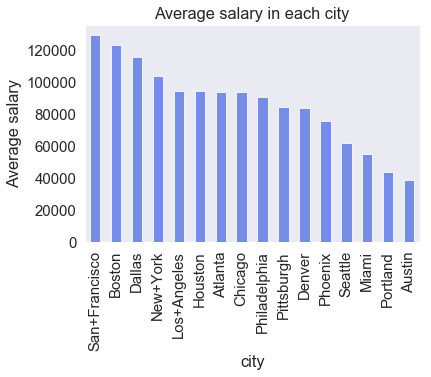

In [31]:
# see the average salary in each city
df.groupby('city').salary.mean().sort_values(ascending=False).plot(kind='bar');
plt.title('Average salary in each city')
plt.ylabel('Average salary');

📝 Things to note:
*  As we can see the highest salary average was in San Fransisco and the lowest was in Austin.

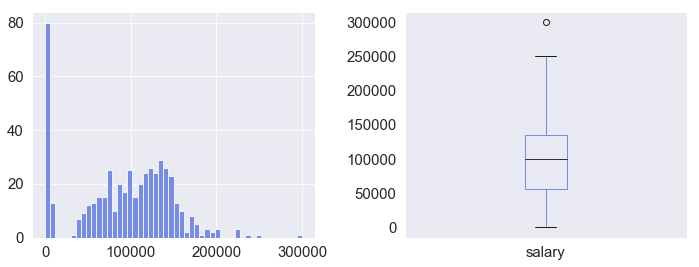

In [40]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
df.salary.hist(bins=50, ax=ax1)
df.salary.plot.box( ax=ax2)

plt.tight_layout() 

📝 Things to note:

* From the histogram and boxplot above we can see the most salary values lies between 5000 and 15000.

* Also, we have that long bar which we can infer from this that the most salary value is less than 10000.

* Also, we have some outliers above 200000.

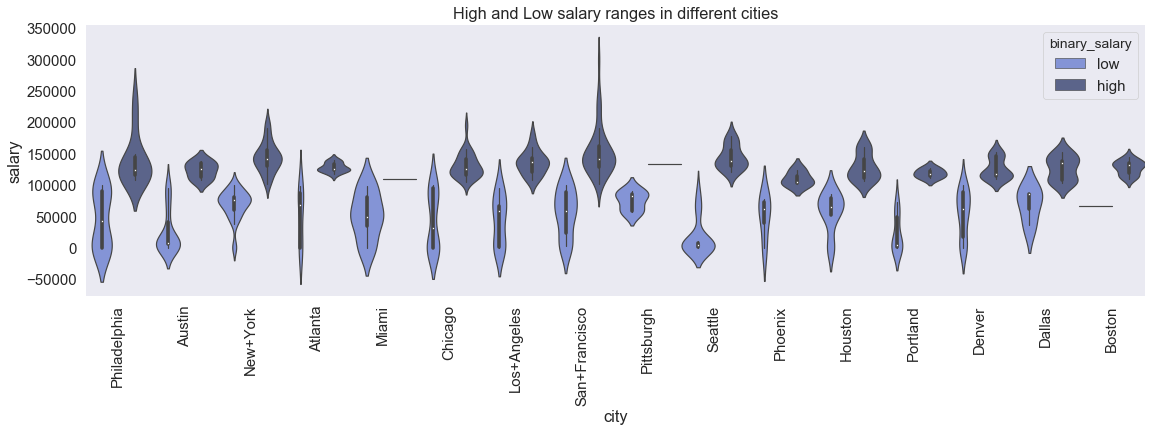

In [41]:
plt.figure(figsize=(19,5))
sns.violinplot(y='salary', x='city', data=df, width=1 , hue='binary_salary');
plt.title('High and Low salary ranges in different cities')
plt.xticks(rotation=90);

📝 Things to note:
* Violin plot above give us a good overview of the range of each high and low salary in each city. As we can see some cites do not have low or high salary like Boston , Pittsburgh and Miami.

---
---

<br><br>
<a id='Modeling'></a>
# 3. Modeling

We are going to try many models then we will choose some of them.

<a id='location'></a>
### 3.1 Modeling based on location property 
---

For this task, we will use **get_dummies** in order to extract the features from the job location.

In [47]:
# convert the location column to dummy variable
X_location = pd.get_dummies(df.city)
y = df.binary_salary.map({'high':1, 'low':0}).values

In [48]:
X_location.shape , y.shape

((502, 16), (502,))

In [50]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import  MultinomialNB

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression


def get_models():

    #base learners
    knn = KNeighborsClassifier()
    dtc = DecisionTreeClassifier()
    rfc = RandomForestClassifier()
    extra_tree = ExtraTreesClassifier()
    log_r = LogisticRegression()
    
    boost = AdaBoostClassifier(n_estimators=50 )
    bagg = BaggingClassifier(n_estimators=500)
    gradi = GradientBoostingClassifier()
    
    xgb = XGBClassifier()

    models = {
              'KNN': knn,
              'Decision Trees': dtc,
              'Random Forest': rfc,
              'Extra tree': extra_tree,
              'LR': log_r,
              
              'AdaBoost': boost,
              'Bagging': bagg,
              'GradientBoost':gradi,
              'XGB':xgb,
              }

    return models



#### Baseline accuracy:

we will baseline line to examine  the performance of our models 

In [51]:
# The baseline accuracy is the proportion of the majority class.
df.binary_salary.value_counts()

low     258
high    244
Name: binary_salary, dtype: int64

In [52]:
(df.binary_salary.value_counts()[0] / len(df.binary_salary))*100

51.39442231075697

In [53]:
#funcation to evaluate a score by cross-validation
def score_cv(model, X=X_location, y=y , score = 'accuracy'):
    k_fold = KFold(n_splits=5, random_state=1, shuffle=True)
    cv_scores = cross_val_score(model, X , y , cv=k_fold, scoring=score)
    return(cv_scores)

In [54]:
# Models comparison
models = get_models()

results = []
for name, model in zip(models.keys(),models.values()):

    f1_scores = score_cv(model)
    results.append(f1_scores)
    print( f"{name} accuracy CV score: {np.mean(f1_scores)} , Std: {f1_scores.std()}.")



KNN accuracy CV score: 0.519940594059406 , Std: 0.056588211353165885.
Decision Trees accuracy CV score: 0.6054653465346534 , Std: 0.030056927329684104.
Random Forest accuracy CV score: 0.6134653465346535 , Std: 0.04765695309106253.
Extra tree accuracy CV score: 0.6054653465346534 , Std: 0.030056927329684104.
LR accuracy CV score: 0.6054653465346534 , Std: 0.030056927329684104.
AdaBoost accuracy CV score: 0.6254653465346535 , Std: 0.03903865854626731.
Bagging accuracy CV score: 0.6154851485148514 , Std: 0.03434799451187142.
GradientBoost accuracy CV score: 0.6054653465346534 , Std: 0.030056927329684104.
XGB accuracy CV score: 0.6054653465346534 , Std: 0.030056927329684104.


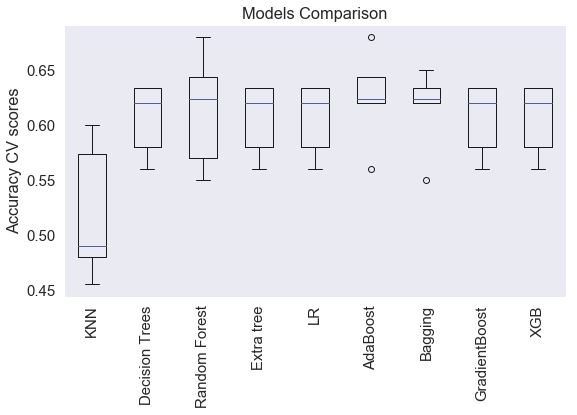

In [55]:
# visualise models comparison
fig = plt.figure( figsize=(9,5))
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels([name for name in models.keys()], rotation=90)
ax.set(title='Models Comparison', ylabel='Accuracy CV scores');

KNN is the worst one !!!

<a id='Importance1'></a>

### 3.1.1 Feature Importance

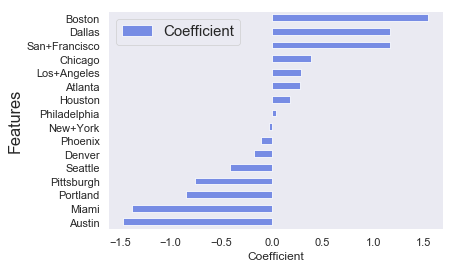

In [57]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scaler', RobustScaler()), ('rf', LogisticRegression())])


model = model.fit(X_location, y)

features = pd.DataFrame()
features['Features'] = X_location.columns
features['Coefficient'] = model.named_steps['rf'].coef_.tolist()[0]
features.sort_values(by=['Coefficient'], ascending=True, inplace=True)
features.set_index('Features', inplace=True)

features.plot(kind='barh',  fontsize=11)
plt.xlabel("Coefficient", fontsize=12);


#### 📝 Summary of what coefficients feature mean:
 

* As the coefficient value (with absolute value) increase, that means the correlation between that variable and our target will also increase.

* Pittsburgh and Miami do not have high salary so this is maybe why they have very small(negative)coefficient values.
* Boston has just high salary so this is maybe why it has large coefficient values.


<br><br>

<a id='categories'></a>

### 3.2 Modeling based on job levels and categories
----

For this task, we will use **NLP (BOW)** in order to extract the features from the job title.

<br>


In [58]:
from sklearn.feature_extraction.text import CountVectorizer
import re

# we will remove numbers and stop words as they will not provide us with helpful information
def no_number(tokens):
    return re.sub('(\d)+', '', tokens.lower())

#we will keep just the word that occurs more than 10 times 
vectorizer = CountVectorizer(lowercase=True, stop_words='english' ,preprocessor=no_number , min_df=12)
X_title = vectorizer.fit_transform(df.title)


# save the vectorized title in new dataframe 
# in order to concatenate with the location features (dummy variable) we extracted above.
df_titel_featurs = pd.DataFrame(X_title.toarray(), columns=vectorizer.get_feature_names())
df_titel_featurs.head()

,analyst,architect,assistant,associate,bureau,data,developer,director,engineer,engineering,...,learning,machine,manager,principal,python,research,scientist,senior,software,sr
0,1,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [59]:
# Concatenate title with the location features.

X = pd.concat([df_titel_featurs.reset_index(), X_location.reset_index()] , axis=1)

In [60]:
X.shape

(502, 39)

### Modeling


As we did above we will try many models then we will choose some of them.

In [61]:
# Models comparison
models = get_models()

results = []
for name, model in zip(models.keys(),models.values()):
    _scores = score_cv(model)
    results.append(_scores)
    print( f"{name} accuracy CV score: {np.mean(_scores)} , Std: {_scores.std()}.")



KNN accuracy CV score: 0.519940594059406 , Std: 0.056588211353165885.
Decision Trees accuracy CV score: 0.6054653465346534 , Std: 0.030056927329684104.
Random Forest accuracy CV score: 0.6194059405940594 , Std: 0.03308608100099364.
Extra tree accuracy CV score: 0.6054653465346534 , Std: 0.030056927329684104.
LR accuracy CV score: 0.6054653465346534 , Std: 0.030056927329684104.
AdaBoost accuracy CV score: 0.6254653465346535 , Std: 0.03903865854626731.
Bagging accuracy CV score: 0.6174851485148515 , Std: 0.030558863410279892.
GradientBoost accuracy CV score: 0.6054653465346534 , Std: 0.030056927329684104.
XGB accuracy CV score: 0.6054653465346534 , Std: 0.030056927329684104.


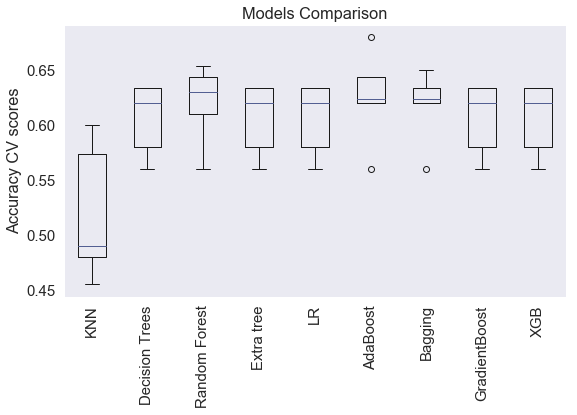

In [62]:
# visualise models comparison
fig = plt.figure( figsize=(9,5))
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels([name for name in models.keys()], rotation=90)
ax.set(title='Models Comparison', ylabel='Accuracy CV scores');

<a id='Importance2'></a>

### Feature Importance

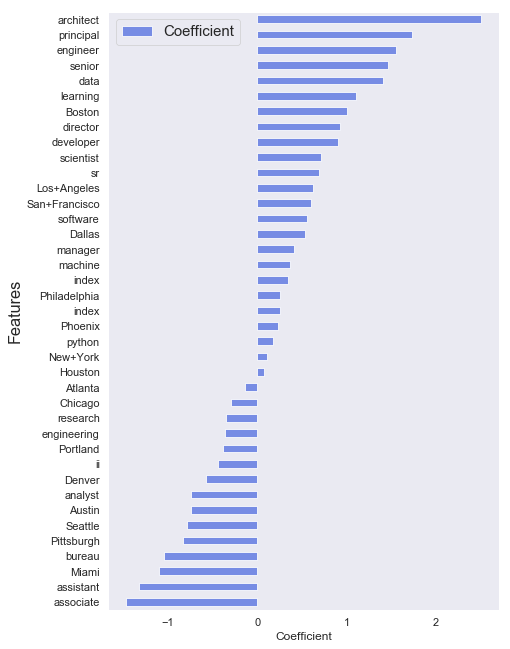

In [64]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scaler', RobustScaler()), ('rf', LogisticRegression())])


model = model.fit(X, y)

features = pd.DataFrame()
features['Features'] = X.columns
features['Coefficient'] = model.named_steps['rf'].coef_.tolist()[0]
features.sort_values(by=['Coefficient'], ascending=True, inplace=True)
features.set_index('Features', inplace=True)

features.plot(kind='barh', figsize=(7, 11), fontsize=11)
plt.xlabel("Coefficient", fontsize=12);

#### 📝 Summary of what coefficients feature mean: 

As the coefficient value (with absolute value) increase, that means the correlation between that variable and our target will also increase.

<br><br>

<a id='Tuning'></a>
### 3.3 Tuning

In [ ]:
# hyperparameters tuning for all models
dict_grid = {
    'rfr': { 'bootstrap': [True, False],
                    'max_depth': [10, 100],
                    'max_features': [5, 14],
                    'n_estimators': [100, 500],
                                    'n_jobs': [-1]},
             
              'etr': { 'n_estimators': [100, 500, 1000],
                      'max_depth': [10, 50, 100],
                    'max_features': range(50,401,50),
                    'min_samples_leaf': range(20,50,5),
                    'min_samples_split': range(15,36,5)
                     'n_jobs': [-1]},
             
              #'log_r': log_r,
              'lin_r': {'n_jobs':[-1]},
              'elastic': {'alpha': np.logspace(0, 5, 100),
                         'l1_ratio': [0.2 , 0.5 , 0.8]},
              
              'boost': {
                         'n_estimators': [50]},
    
              'bagg': { 'n_estimators': [ 500]},
              'gradi':{'learning_rate': [0.1],
                         'loss': ['ls'],
                         'max_depth': [3],
                         'max_features': ['log2'],
                         'n_estimators': [500],
                         'subsample': [0.8]},
                'xgb': {'n_estimators': [50] , ''}
              }


In [ ]:
# Models comparison
models = get_models()

tunned_models = []
for name, model , param in zip(models.keys(), models.values(), dict_grid.keys() ):
    
    tunned_model = GridSearchCV(model, param_grid = dict_grid[param] ,cv=5 , scoring='neg_mean_squared_error')
    tunned_model.fit(X_train_pca, y)
    print( name)
    print('best score: ',np.sqrt(-tunned_model.best_score_))
    print('best params: ',tunned_model.best_params_)
    print('_____________________________\n'*2)

<br><br>

<a id='Evaluation'></a>
### 3.4 Evaluation
---
 
We will evaluate our models by doing the following:

- Evaluate the AUC, precision and recall of the models. 
- Plot the ROC and precision-recall curves for the best model based on cross-validation scores.



<a id='AUC'></a>
#### 3.4.1 Evaluate models based on AUC score


In [65]:
# Models comparison
models = get_models()

results = []
for name, model in zip(models.keys(),models.values()):
    _scores = score_cv(model , score='roc_auc')
    results.append(_scores)
    print( f"{name} AUC CV score: {np.mean(_scores)} , Std: {_scores.std()}.")



KNN AUC CV score: 0.5767743965933066 , Std: 0.05384707946050757.
Decision Trees AUC CV score: 0.6771303766073233 , Std: 0.039807326720181155.
Random Forest AUC CV score: 0.6790965517423806 , Std: 0.04693076174889478.
Extra tree AUC CV score: 0.6771303766073233 , Std: 0.039807326720181155.
LR AUC CV score: 0.6755342147604138 , Std: 0.04010411386463554.
AdaBoost AUC CV score: 0.6771287039189786 , Std: 0.03972447556962138.
Bagging AUC CV score: 0.6749685121524363 , Std: 0.04073652283968095.
GradientBoost AUC CV score: 0.6727991406400652 , Std: 0.04059520891547273.
XGB AUC CV score: 0.6747610404663419 , Std: 0.04041231774786077.


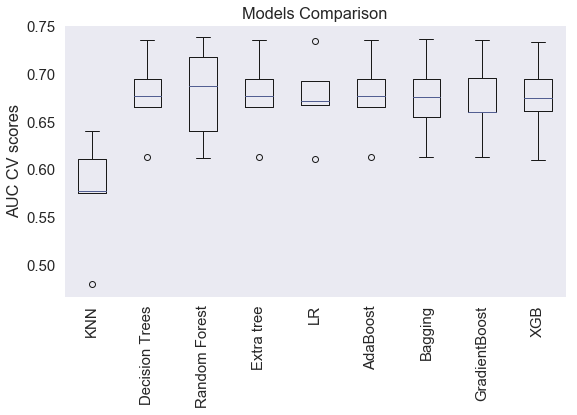

In [66]:
# visualise models comparison
fig = plt.figure( figsize=(9,5))
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels([name for name in models.keys()], rotation=90)
ax.set(title='Models Comparison', ylabel='AUC CV scores');

<br><br>

<a id='recall'></a>
#### 3.4.2 Evaluate models based on recall score
---
##### Recall:
* Is the ratio of correctly predicted high salary jobs to the all high salary jobs class

**The question that this metric answer is:**


how much of all truly high salary jobs we missed ??

or (in another way):


Of all the jobs that truly high salary, how many did we label?



In [67]:
# Models comparison
models = get_models()

results = []
for name, model in zip(models.keys(),models.values()):
    _scores = score_cv(model , score='recall')
    results.append(_scores)
    print( f"{name} recall CV score: {np.mean(_scores)} , Std: {_scores.std()}.")



KNN recall CV score: 0.5794639461752231 , Std: 0.1214959522996421.
Decision Trees recall CV score: 0.46508117595436593 , Std: 0.09185218124172055.
Random Forest recall CV score: 0.496488152698552 , Std: 0.13856426771585054.
Extra tree recall CV score: 0.46508117595436593 , Std: 0.09185218124172055.
LR recall CV score: 0.46508117595436593 , Std: 0.09185218124172055.
AdaBoost recall CV score: 0.5220780313002779 , Std: 0.06535696976582982.
Bagging recall CV score: 0.5149836916776364 , Std: 0.04970379907768007.
GradientBoost recall CV score: 0.46508117595436593 , Std: 0.09185218124172055.
XGB recall CV score: 0.46508117595436593 , Std: 0.09185218124172055.


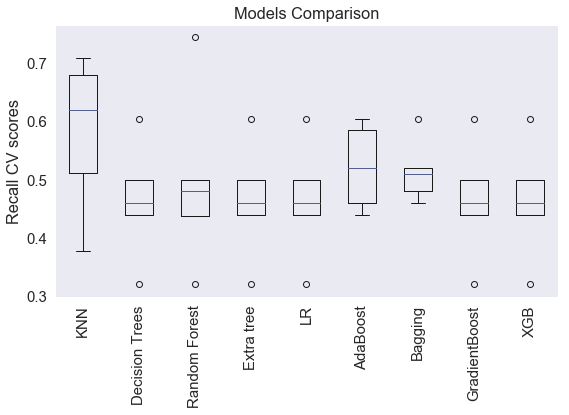

In [68]:
# visualise models comparison
fig = plt.figure( figsize=(9,5))
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels([name for name in models.keys()], rotation=90)
ax.set(title='Models Comparison', ylabel='Recall CV scores');

<br><br>
<a id='precision'></a>
#### 3.4.3 Evaluate models based on precision score
---
##### Precision:
Is the ratio of correctly predicted high salary jobs to the total predicted high salary jobs

**The question that this metric answer is:**

how much jobs we predicted as high salary but actually they are not ??




In [69]:
# Models comparison
models = get_models()

results = []
for name, model in zip(models.keys(),models.values()):
    _scores = score_cv(model , score='precision')
    results.append(_scores)
    print( f"{name} precision CV score: {np.mean(_scores)} , Std: {_scores.std()}.")



KNN precision CV score: 0.5058874737130182 , Std: 0.06519091113412445.
Decision Trees precision CV score: 0.643099294947121 , Std: 0.06622280972764233.
Random Forest precision CV score: 0.6366981433789493 , Std: 0.07251318762188265.
Extra tree precision CV score: 0.643099294947121 , Std: 0.06622280972764233.
LR precision CV score: 0.643099294947121 , Std: 0.06622280972764233.
AdaBoost precision CV score: 0.6459367574358834 , Std: 0.07434999306807032.
Bagging precision CV score: 0.6471224256292907 , Std: 0.0696279619632104.
GradientBoost precision CV score: 0.643099294947121 , Std: 0.06622280972764233.
XGB precision CV score: 0.643099294947121 , Std: 0.06622280972764233.


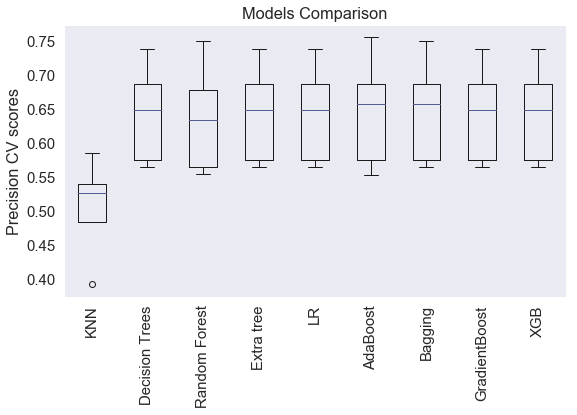

In [70]:
# visualise models comparison
fig = plt.figure( figsize=(9,5))
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels([name for name in models.keys()], rotation=90)
ax.set(title='Models Comparison', ylabel='Precision CV scores');

<br><br>


### Plot the ROC:

 ROC is a plot of signal (True Positive Rate) against noise (False Positive Rate). 

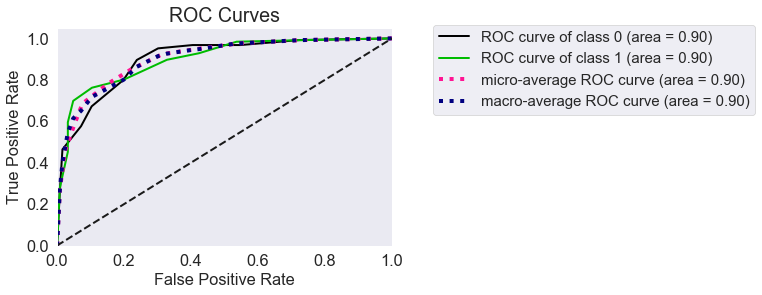

In [78]:
# roc curve and auc
from sklearn.model_selection import train_test_split
import scikitplot as skplt


# split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

# fit a model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# predict probabilities
probs = model.predict_proba(X_test)


skplt.metrics.plot_roc(y_test, probs)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

#### Interpretation of ROC curves

A classifier with the perfect performance level shows a combination of two straight lines – from the origin (0.0, 0.0) to the top left corner (0.0, 1.0) and further to the top right corner (1.0, 1.0).

But it is important to notice that classifiers with meaningful performance levels usually lie in the area between the random ROC curve (baseline) and the perfect ROC curve as we got in our plot above [1].

<br><br>
<br><br>


### Plot precision-recall curves:



In [72]:
from sklearn.metrics import average_precision_score, precision_recall_curve

average_precision = average_precision_score(y_test, probs[:,1])

print('Average precision-recall score XGB: {}'.format(average_precision))

Average precision-recall score XGB: 0.8970693487154434


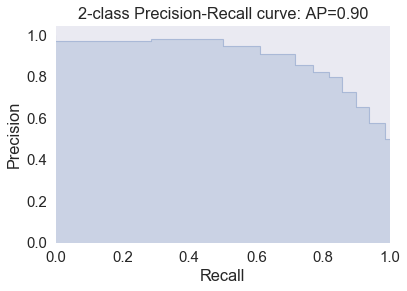

In [73]:
precision, recall, _ = precision_recall_curve(y_test, probs[:,1])

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,  color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format( average_precision));

#### Interpretation of precision-recall curves:



A classifier with the random performance level shows a horizontal line as P / (P + N). This line separates the precision-recall space into two areas. The separated area above the line is the area of good performance levels. The other area below the line is the area of poor performance. [2]


---
---
<br><br>
<a id='conclusion'></a>
# Conclusion

In this Tutorial, we have focused on the problem of modeling and predicting the salary level based on the location and title of the job.
  
We tested a variety of classification models, including Random Forest, Extra tree, LR,  GradientBoost, XGB and AdaBoost. We optimized the parameters of each of these methods, validated the performance of each model using cross validation and compared the performance of these models.
The best result we achieved was with AdaBoost model (71%).

In the future I'm hoping to build on and refine this model, extending its accuracy and predictive ability by employing Other NLP techniques, such as using longer strings of words as features such as bigrams and trigrams. Another option would be using the job description as a feature.
<br><br>

## References:


[1] https://classeval.wordpress.com/introduction/introduction-to-the-roc-receiver-operating-characteristics-plot/


[2] https://classeval.wordpress.com/introduction/introduction-to-the-precision-recall-plot/